In [9]:
from datetime import datetime as dt

import pandas as pd
import numpy as np

from preprocessing import Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample



from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay

# Preprocessing

In [10]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [11]:
train.shape

(165034, 11)

In [12]:
X = train.drop(columns='Exited')
y = train.Exited

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y, test_size=0.15)

In [14]:
prepro = Preprocessing()

In [15]:
X_train_scld = prepro.fit_transform(X_train)
X_test_scld = prepro.transform(X_test)

In [16]:
X_train_balanced, y_train_balanced = resample(X_train_scld[y_train == 1], y_train[y_train == 1], n_samples=np.sum(y_train == 0), replace=True, random_state=42)

In [17]:
X_train_balanced = np.concatenate((X_train_scld[y_train == 0], X_train_balanced))
y_train_balanced = np.concatenate((y_train[y_train == 0], y_train_balanced))

# Model

In [52]:
results = {
    'models' : [
        ('rf', RandomForestClassifier()),
        ('histgradboost', HistGradientBoostingClassifier()),
        ('gradboost', GradientBoostingClassifier()),
        ('adaboost', AdaBoostClassifier())
        ],
    'mean_score' :[],
    'std_dev_score' :[] 
}
for _, model in results.get('models') :
    scores = cross_val_score(model,
                            X_train_balanced,
                            y_train_balanced,
                            scoring = 'roc_auc',
                            cv = 4,
                            n_jobs = -1)
    results['mean_score'].append(scores.mean())
    results['std_dev_score'].append(scores.std())
    
    name = type(model).__name__ 
    print(f'{name} - Roc AUC score: {scores.mean():.4f} ± {scores.std():.4f}')

RandomForestClassifier - Roc AUC score: 0.9878 ± 0.0005
HistGradientBoostingClassifier - Roc AUC score: 0.8961 ± 0.0010
GradientBoostingClassifier - Roc AUC score: 0.8902 ± 0.0010
AdaBoostClassifier - Roc AUC score: 0.8806 ± 0.0013


In [54]:
voting = VotingClassifier(
    estimators=results.get('models'),
    voting='soft',
    weights=results.get('mean_score')
)

In [59]:
voting.fit(X_train_balanced,y_train_balanced)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('histgradboost',
                              HistGradientBoostingClassifier()),
                             ('gradboost', GradientBoostingClassifier()),
                             ('adaboost', AdaBoostClassifier())],
                 voting='soft',
                 weights=[0.987849062645034, 0.8960886499653947,
                          0.8902226744115429, 0.880602029261191])

In [61]:
pred = voting.predict(X_test_scld)
pred_proba = voting.predict_proba(X_test_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, b

# Score

In [62]:
RocScore  = roc_auc_score(y_test, pred_proba)
print(f'Roc Auc Score : {RocScore:.6f}')

Roc Auc Score : 0.889552


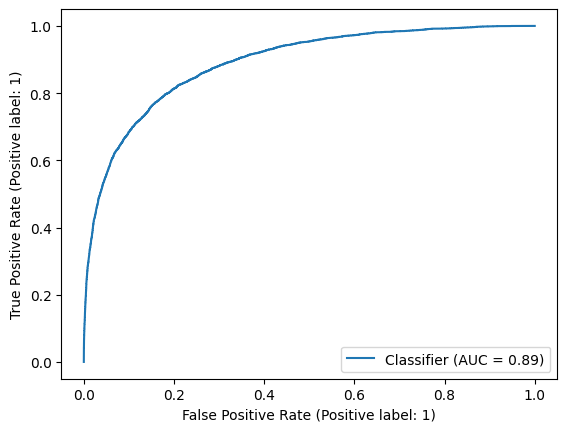

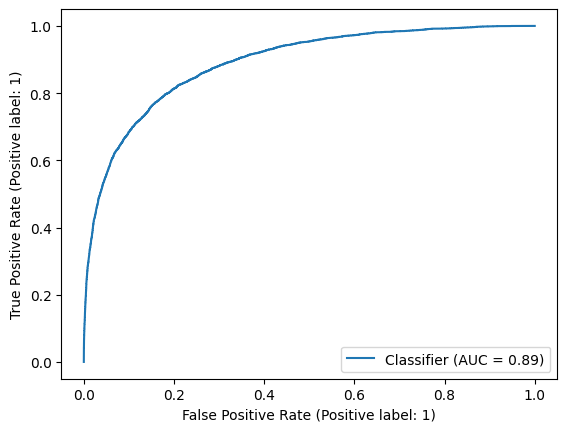

In [63]:
RocCurveDisplay.from_predictions(y_test,pred_proba).plot()

In [64]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89     19518
           1       0.60      0.73      0.66      5238

    accuracy                           0.84     24756
   macro avg       0.76      0.80      0.78     24756
weighted avg       0.85      0.84      0.84     24756



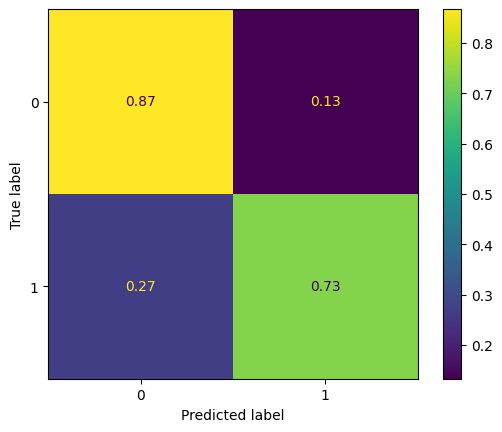

In [65]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pred, normalize='true')).plot()

# Submission

In [66]:
X_val_scld = prepro.transform(test)

In [67]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [69]:
submission.loc[:,'Exited'] = voting.predict_proba(X_val_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but HistGradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, b

In [70]:
submission

,Exited
id,
165034,0.154615
165035,0.837039
165036,0.167866
165037,0.436906
165038,0.547379
...,...
275052,0.204436
275053,0.298597
275054,0.153810


In [71]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [ ]:
submission.to_csv(f"submission/{name}.csv")